In [2]:
import torch
from torch import Tensor, nn
from torchinfo import summary
import math

* EfficientNet
* 논문 : https://arxiv.org/pdf/1905.11946
* 참조 : https://velog.io/@krec7748/Pytorch-EfficientNet-%EA%B5%AC%ED%98%84

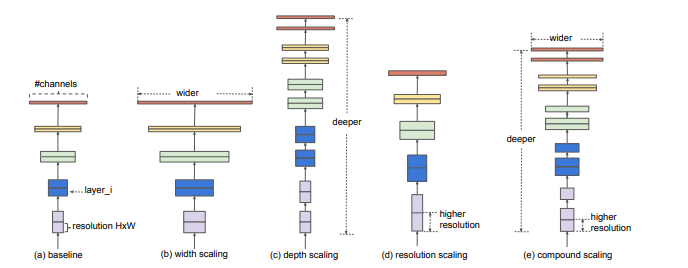

In [3]:
from torchvision.ops import StochasticDepth

<img src = 'https://velog.velcdn.com/images%2Fiissaacc%2Fpost%2F4688e64e-c998-4285-8229-c39659bcc08c%2Fimage.png'>

* Scaling Factor
* alpha = width : 넓이
* beta = depth : 깊이
* gamma = resolution : 해상도

In [4]:
def _make_divisible(v, divisor, min_value = None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return int(new_v)
_make_divisible(32, 8)

32

In [10]:
class SEBlock(nn.Module):
    '''
    Mobilenetv3는 확장채널을 기준으로 excitation을 수행하지만,
    EfficientNet은 입력채널을 기준으로 excitation을 수행함!
    '''
    def __init__(self, in_channels, inner_channels, reduction = 4):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(inner_channels, in_channels // reduction),
            nn.SiLU(),
            nn.Linear(in_channels // reduction, inner_channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        out = self.squeeze(x).view(b,-1)
        out = self.excitation(out).view(b,c,1,1)
        return out * x

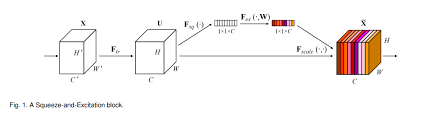

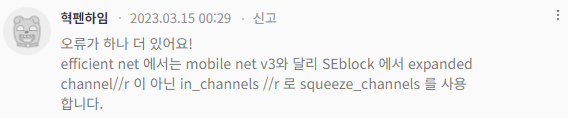

In [6]:
class MBConv(nn.Module):
    def __init__(self, in_channels, inner_channels, out_channels, kernel_size, stride, sd_prob):
        super().__init__()
        
        self.use_skip_connection = (stride == 1 and in_channels == out_channels)
        self.stochastic = StochasticDepth(sd_prob, mode = 'row')
        
        expand = nn.Sequential(
            nn.Conv2d(in_channels, inner_channels, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(inner_channels, momentum = 0.99),
            nn.SiLU()
        )
        depthwise = nn.Sequential(
            nn.Conv2d(inner_channels, inner_channels, kernel_size = kernel_size, 
                      stride = stride, padding = (kernel_size - 1) // 2, 
                      groups = inner_channels, bias = False),
            nn.BatchNorm2d(inner_channels, momentum = 0.99),
            nn.SiLU()
        )
        se_block = SEBlock(in_channels, inner_channels)
        pointwise = nn.Sequential(
            nn.Conv2d(inner_channels, out_channels, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(out_channels, momentum = 0.99),
        )
        
        layers = []
        if in_channels < inner_channels:
            '''
            Inverted Residual Block
            '''
            layers += [expand]
        layers += [depthwise, se_block, pointwise]
        
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.use_skip_connection:
            out = self.block(x)
            out = self.stochastic(out)
            out += x
            return out
        else:
            out = self.block(x)
            return out

<img src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fbwiouy%2FbtrCW1A2Q1u%2FmoV8u2hxJ27x87fKWLPSA0%2Fimg.png'>

In [7]:
class EfficientNet_blueprint(nn.Module):
    def __init__(self, num_classes, depth_mult, width_mult, dropout_p, stochastic_depth_p = 0.2, resize_size = 256, crop_size = 224):
        super().__init__()
        
        cfgs =cfgs = [
           #[k, t,  c, n, s]
            [3, 1, 16, 1, 1],
            [3, 6, 24, 2, 2],
            [5, 6, 40, 2, 2],
            [3, 6, 80, 3, 2],
            [5, 6, 112, 3, 1],
            [5, 6, 192, 4, 2],
            [3, 6, 320, 1, 1],
        ]

        
        in_channels = _make_divisible(32 * width_mult, 8)
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, in_channels, kernel_size = 3, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(in_channels, momentum = 0.99),
            nn.SiLU()
        )
        
        layers = []
        num_block = 0
        num_total_layers = sum(math.ceil(cfg[-2] * depth_mult) for cfg in cfgs)
        for k, t, c, n, s in cfgs:
            n = math.ceil(n * depth_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                inner_channels = _make_divisible(in_channels * t, 8)
                out_channels = _make_divisible(c * width_mult, 8)
                sd_prob = stochastic_depth_p * (num_block / (num_total_layers - 1))

                layers.append(MBConv(in_channels = in_channels, 
                                     inner_channels = inner_channels, 
                                     out_channels = out_channels,
                                     kernel_size = k, stride = stride, sd_prob = sd_prob))
                in_channels = out_channels
                num_block += 1
        self.layers = nn.Sequential(*layers)
        
        last_channels = _make_divisible(1280 * width_mult, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, last_channels, kernel_size = 1, bias = False),
            nn.BatchNorm2d(last_channels, momentum = 0.99),
            nn.SiLU()
        )
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Dropout(p = dropout_p),
            nn.Linear(last_channels, num_classes)
        )
        
        self._init_layer()

    def _init_layer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity = 'relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.layers(out)
        out = self.conv2(out)
        out = self.avg(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [8]:
def EfficientNet(model_type, num_classes = 1000, **kwargs):
    if model_type == 'b0':
        '''
        * resolution = 224
        '''
        return EfficientNet_blueprint(num_classes = num_classes, depth_mult = 1.0, width_mult = 1.0, dropout_p = 0.2, **kwargs)
    elif model_type == 'b1':
        '''
        * resolution = 240
        '''
        return EfficientNet_blueprint(num_classes = num_classes, depth_mult = 1.1, width_mult = 1.0, dropout_p = 0.2, **kwargs)
    elif model_type == 'b2':
        '''
        * resolution = 288
        '''
        return EfficientNet_blueprint(num_classes = num_classes, depth_mult = 1.2, width_mult = 1.1, dropout_p = 0.3, **kwargs)
    elif model_type == 'b3':
        '''
        * resolution = 300
        '''
        return EfficientNet_blueprint(num_classes = num_classes, depth_mult = 1.4, width_mult = 1.2, dropout_p = 0.3, **kwargs)
    elif model_type == 'b4':
        '''
        * resolution = 380
        '''
        return EfficientNet_blueprint(num_classes = num_classes, depth_mult = 1.8, width_mult = 1.4, dropout_p = 0.4, **kwargs)
    elif model_type == 'b5':
        '''
        * resolution = 456
        '''
        return EfficientNet_blueprint(num_classes = num_classes, depth_mult = 2.2, width_mult = 1.6, dropout_p = 0.4, **kwargs)
    elif model_type == 'b6':
        '''
        * resolution = 528
        '''
        return EfficientNet_blueprint(num_classes = num_classes, depth_mult = 2.6, width_mult = 1.8, dropout_p = 0.5, **kwargs)
    elif model_type == 'b7':
        '''
        * resolution = 600
        '''
        return EfficientNet_blueprint(num_classes = num_classes, depth_mult = 3.1, width_mult = 2.0, dropout_p = 0.5, **kwargs)
    else:
        raise ValueError('only select b0~7')

In [12]:
summary(EfficientNet('b0'), (1,3,224,224))

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet_blueprint                             [1, 1000]                 --
├─Sequential: 1-1                                  [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                                 [1, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                            [1, 32, 112, 112]         64
│    └─SiLU: 2-3                                   [1, 32, 112, 112]         --
├─Sequential: 1-2                                  [1, 320, 7, 7]            --
│    └─MBConv: 2-4                                 [1, 16, 112, 112]         --
│    │    └─Sequential: 3-1                        [1, 16, 112, 112]         1,448
│    └─MBConv: 2-5                                 [1, 24, 56, 56]           --
│    │    └─Sequential: 3-2                        [1, 24, 56, 56]           6,004
│    └─MBConv: 2-6                                 [1, 24, 56, 56]           --
│    │    └─Sequential: 3-3 

In [13]:
from torchvision.models import efficientnet_b0
summary(efficientnet_b0(), (1,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              